In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import glob
import numpy as np
import pandas as pd
from pandas import Series
from pandas import Series, DataFrame
import math
import os
import zipfile
import shutil
import ast
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import statistics
from sklearn.svm import SVC
from sklearn.model_selection import (train_test_split, GridSearchCV, RepeatedStratifiedKFold)
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,classification_report,precision_score,recall_score,auc, roc_curve, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import (LabelEncoder,OneHotEncoder, StandardScaler)  
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import datasets
from sklearn import metrics
import keras
import keras.optimizers as optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.utils.vis_utils import plot_model
#from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

# Descargando la base de datos de Metadata

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alonsopuente","key":"a2490af4bf49c88fb2df45cdbad9784f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Cambiamos los permisos
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alonsopuente/kickstarter-projects-metadata
!ls

 86% 5.00M/5.78M [00:01<00:00, 3.79MB/s]
100% 5.78M/5.78M [00:01<00:00, 4.28MB/s]
kaggle.json  kickstarter-projects-metadata.zip	sample_data


In [ ]:
os.mkdir('folder')
zip_train_test_md = zipfile.ZipFile('kickstarter-projects-metadata.zip','r')
zip_train_test_md.extractall()
zip_train_test_md.close()
os.rename('kickstarter-projects-metadata.zip','folder/kickstarter-projects-metadata.zip')
shutil.rmtree('folder')

# Cargando la BD

In [ ]:
data_final = pd.read_csv("Metadata.csv",sep = ',')
data_final.head()

,id,backers_count,name,blurb,category,photo,urls,city,country,goal,pledge_amounts,pledged,currency,usd_pledged,created_at,launched_at,deadline,duration,state
0,1000245024,0,Safer Home,Placing furniture against traditional plugs is...,Hardware,https://ksr-ugc.imgix.net/assets/011/663/874/0...,https://www.kickstarter.com/projects/homesafet...,Kamloops,CA,50000.0,[10],0.0,CAD,0.000000,"March 09, 2014","June 03, 2015","July 03, 2015",30,failed
1,1000256230,0,Shreddit - Privacy on Reddit,"Shreddit, a Reddit privacy tool I created and ...",Software,https://ksr-ugc.imgix.net/assets/013/466/903/0...,https://www.kickstarter.com/projects/466914929...,Edinburgh,GB,2000.0,"[10, 25, 35, 50]",0.0,GBP,0.000000,"August 23, 2016","June 02, 2017","July 02, 2017",30,failed
2,1000261018,3,Diposta - liberating people from their postal ...,The problem of mail: it is physical! Diposta c...,Web,https://ksr-ugc.imgix.net/assets/012/071/808/1...,https://www.kickstarter.com/projects/105350477...,Raleigh,US,100000.0,"[40, 99, 199]",141.0,USD,141.000000,"March 17, 2015","July 24, 2016","August 23, 2016",30,failed
3,100039820,3,Best Spray Bottle Ever - SureShot,Ever had a spray bottle that has a little bit ...,Gadgets,https://ksr-ugc.imgix.net/assets/012/009/461/3...,https://www.kickstarter.com/projects/110136848...,Edmonton,CA,25000.0,[10],3.0,CAD,2.411101,"January 22, 2015","February 05, 2015","March 07, 2015",30,failed
4,1000468345,6,The iRNinja - Simplify your TV with a wireless...,Control your TV & Audio/Video components by pr...,Gadgets,https://ksr-ugc.imgix.net/assets/016/561/251/1...,https://www.kickstarter.com/projects/5877985/i...,Jupiter,US,500.0,"[1, 10, 249, 300, 375, 425]",74.0,USD,74.000000,"April 27, 2017","May 10, 2017","June 14, 2017",35,failed


In [ ]:
data_final.dtypes

id                  int64
backers_count       int64
name               object
blurb              object
category           object
photo              object
urls               object
city               object
country            object
goal              float64
pledge_amounts     object
pledged           float64
currency           object
usd_pledged       float64
created_at         object
launched_at        object
deadline           object
duration            int64
state              object
dtype: object

In [ ]:
# 0: id
# 4: category
# 8: country
# 9: goal
# 10: pledge_amounts
# 12: currency
# 17: duration
# state
metadata = data_final.iloc[:, [1,4,8,9,10,11,12,13,17,18]]

# Convirtiendo string de pledge_amounts a lista (ahora posición 4)
metadata.iloc[:, 4] = metadata.iloc[:, 4].apply(lambda s: list(ast.literal_eval(s)))

# Aquellas sin categorías (ahora posición 1) las llenamos con un valor
metadata.iloc[:, 1] = metadata.iloc[:, 1].fillna('No information') # <-- add this line

pledges_median = []
pledge_max = []
pledge_min = []
pledge_std = []
pledges_mean = []
pledges_num = []
completness = []
j = 0
for i in metadata.iloc[:, 4]:  

  pledges_num.append(len(i))

  rate_comp = (metadata.iloc[j,5]/metadata.iloc[j,3])*100.0
  completness.append(rate_comp)
 
  if( len(i) > 1 ):
    mean_vector = statistics.mean(i)
    median_vector = statistics.median(i)
    minx = min(list(i))
    maxx = max(i)
    stdx = statistics.stdev(i)
    pledges_median.append(median_vector)
    pledges_mean.append(mean_vector)
    pledge_max.append(maxx)
    pledge_min.append(minx)
    pledge_std.append(stdx)
  else:
    mean_vector = i[0] if len(i) == 1 else 0
    pledges_median.append(mean_vector)
    pledges_mean.append(mean_vector)
    pledge_max.append(mean_vector)
    pledge_min.append(mean_vector)
    pledge_std.append(0)

  j += 1

metadata['pledges_median'] = pledges_median
metadata['pledges_mean'] = pledges_mean
metadata['pledges_min'] = pledge_min
metadata['pledges_max'] = pledge_max
metadata['pledges_std'] = pledge_std
metadata['pledges_num'] = pledges_num
metadata['completeness'] = completness
metadata = metadata.reindex(columns=['backers_count','category','country','currency','goal','pledge_amounts','pledges_median','pledges_mean','pledges_min','pledges_max','pledges_std','pledges_num','pledged','completeness','usd_pledged','duration','state'])
metadata.head(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

,backers_count,category,country,currency,goal,pledge_amounts,pledges_median,pledges_mean,pledges_min,pledges_max,pledges_std,pledges_num,pledged,completeness,usd_pledged,duration,state
0,0,Hardware,CA,CAD,50000.0,[10],10.0,10.000000,10,10,0.000000,1,0.0,0.000000,0.000000,30,failed
1,0,Software,GB,GBP,2000.0,"[10, 25, 35, 50]",30.0,30.000000,10,50,16.832508,4,0.0,0.000000,0.000000,30,failed
2,3,Web,US,USD,100000.0,"[40, 99, 199]",99.0,112.666667,40,199,80.376199,3,141.0,0.141000,141.000000,30,failed
3,3,Gadgets,CA,CAD,25000.0,[10],10.0,10.000000,10,10,0.000000,1,3.0,0.012000,2.411101,30,failed
4,6,Gadgets,US,USD,500.0,"[1, 10, 249, 300, 375, 425]",274.5,226.666667,1,425,181.705990,6,74.0,14.800000,74.000000,35,failed
5,12,Software,IE,EUR,4000.0,"[5, 10, 50]",10.0,21.666667,5,50,24.664414,3,282.0,7.050000,313.300263,30,failed
6,1,Web,US,USD,15000.0,"[25, 100]",62.5,62.500000,25,100,53.033009,2,25.0,0.166667,25.000000,18,failed
7,2,Hardware,US,USD,6000.0,"[10, 200, 500]",200.0,236.666667,10,500,247.049253,3,20.0,0.333333,20.000000,40,failed
8,4,Flight,US,USD,8500.0,"[10, 25, 55, 110, 510, 1010]",82.5,286.666667,10,1010,400.745139,6,1355.0,15.941176,1355.000000,45,failed
9,561,Hardware,US,USD,250000.0,"[1, 35, 40, 50, 445, 495, 499, 525, 545, 895, ...",499.0,1848.461538,1,10000,3522.576250,13,268192.0,107.276800,268192.000000,41,successful


In [ ]:
# Ahora que se ha imputado los nulos de las categorías, verificar si existen en otras columnas
null_columns=metadata.columns[metadata.isnull().any()]
metadata[null_columns].isnull().sum()

Series([], dtype: float64)

## Análisis exploratorio

In [ ]:
metadata.category.value_counts()

Apps                          6602
Web                           3693
Hardware                      3542
Gadgets                       3173
Software                      2973
Wearables                     1222
Technology                    1111
DIYTechnologyElectronics      1013
Sound                          753
3DTechnologyPrinting           699
Robots                         593
CameraTechnologyEquipment      462
Flight                         383
SpaceTechnologyExploration     335
FabricationTechnologyTools     266
Makerspaces                    246
No information                 185
Name: category, dtype: int64

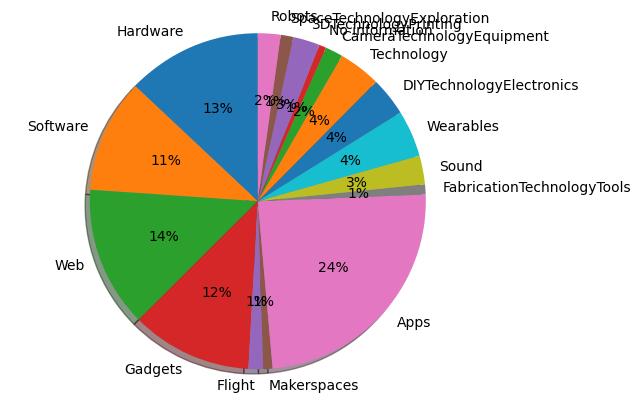

In [ ]:
plt.rcdefaults()

# Almacenar nombres de subcategorías de Tecnología
category_values = [metadata.category.unique()[i] for i in range(0,len(metadata.category.value_counts())) if str(metadata.category.unique()[i]) != 'nan']

# Almacenar la cantidad de subcategorías de Tecnología
category_count = [len(metadata[metadata['category']== metadata.category.unique()[i]]) for i in range(0,len(metadata.category.value_counts())) if len(metadata[metadata['category']== metadata.category.unique()[i]]) != 0]
#colors_category = ["#75FF33", "#FF5733"]
#category_explode = (0, 0.1)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(category_count)
        val = int(round(pct*total/100.0))
        return '{p:.0f}%'.format(p=pct,v=val)
        #return '{p:.0f}%  ({v:,})'.format(p=pct,v=val)
    return my_autopct

fig1, ax1 = plt.subplots()
ax1.pie(category_count, labels=category_values, autopct=make_autopct(category_count),
        shadow=True, startangle=90)
ax1.axis('equal')  # Para dibujar pie como un círculo

#plt.title("Distribución de proyectos por subcategorías", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

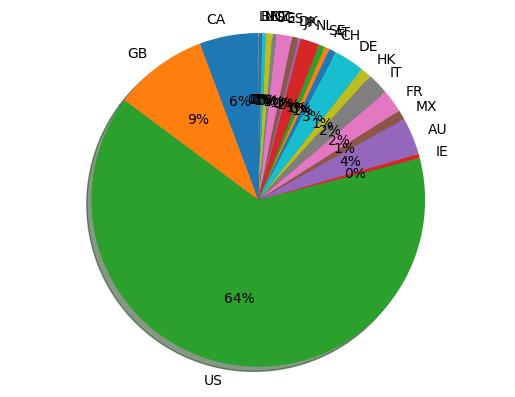

In [ ]:
plt.rcdefaults()

# Almacenar nombres de países
country_values = [metadata.country.unique()[i] for i in range(0,len(metadata.country.value_counts())) if str(metadata.country.unique()[i]) != 'nan']

# Almacenar la cantidad de países
country_count = [len(metadata[metadata['country']== metadata.country.unique()[i]]) for i in range(0,len(metadata.country.value_counts())) if len(metadata[metadata['country']== metadata.country.unique()[i]]) != 0]
#colors_country = ["#75FF33", "#FF5733"]
#country_explode = (0, 0.1)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(country_count)
        val = int(round(pct*total/100.0))
        return '{p:.0f}%'.format(p=pct,v=val)
        #return '{p:.0f}%  ({v:,})'.format(p=pct,v=val)
    return my_autopct

fig1, ax1 = plt.subplots()
ax1.pie(country_count, labels=country_values, autopct=make_autopct(country_count),
        shadow=True, startangle=90)
ax1.axis('equal')  # Para dibujar pie como un círculo

#plt.title("Distribución de proyectos por divisas", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

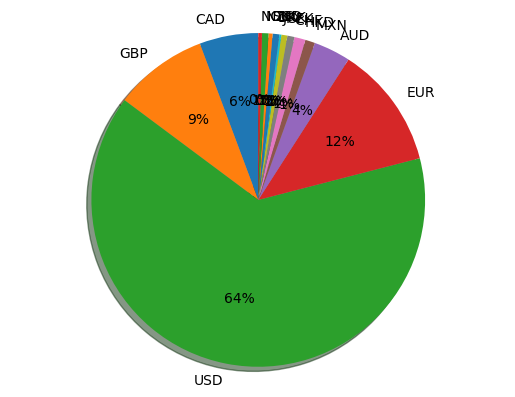

In [ ]:
plt.rcdefaults()

# Almacenar nombres de divisas
currency_values = [metadata.currency.unique()[i] for i in range(0,len(metadata.currency.value_counts())) if str(metadata.currency.unique()[i]) != 'nan']

# Almacenar la cantidad de divisas
currency_count = [len(metadata[metadata['currency']== metadata.currency.unique()[i]]) for i in range(0,len(metadata.currency.value_counts())) if len(metadata[metadata['currency']== metadata.currency.unique()[i]]) != 0]
#colors_currency = ["#75FF33", "#FF5733"]
#currency_explode = (0, 0.1)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(currency_count)
        val = int(round(pct*total/100.0))
        return '{p:.0f}%'.format(p=pct,v=val)
        #return '{p:.0f}%  ({v:,})'.format(p=pct,v=val)
    return my_autopct

fig1, ax1 = plt.subplots()
ax1.pie(currency_count, labels=currency_values, autopct=make_autopct(currency_count),
        shadow=True, startangle=90)
ax1.axis('equal')  # Para dibujar pie como un círculo

#plt.title("Distribución de proyectos por divisas", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [ ]:
metadata.columns

Index(['backers_count', 'category', 'country', 'currency', 'goal',
       'pledge_amounts', 'pledges_median', 'pledges_mean', 'pledges_min',
       'pledges_max', 'pledges_std', 'pledges_num', 'pledged', 'completeness',
       'usd_pledged', 'duration', 'state'],
      dtype='object')

In [ ]:
metadata.iloc[:, [0,4,6,7,8,9,10,11,12,13,14,15]].describe().T

,count,mean,std,min,25%,50%,75%,max
backers_count,27251.0,208.710469,1.179682e+03,0.0,2.000000,9.000000,70.000000,1.058570e+05
goal,27251.0,91263.966580,1.259282e+06,1.0,5000.000000,18000.000000,50000.000000,1.000000e+08
pledges_median,27251.0,370.979138,5.021245e+03,0.0,32.500000,75.000000,175.000000,5.440000e+05
pledges_mean,27251.0,707.519160,5.932414e+03,0.0,50.000000,174.000000,560.585227,6.090000e+05
pledges_min,27251.0,136.248284,3.735749e+03,0.0,1.000000,5.000000,20.000000,3.920000e+05
pledges_max,27251.0,2609.787641,1.763527e+04,0.0,100.000000,500.000000,2325.000000,1.200000e+06
pledges_std,27251.0,898.286884,5.925608e+03,0.0,34.177233,179.886869,739.787829,4.429432e+05
pledges_num,27251.0,6.222010,4.131041e+00,0.0,3.000000,6.000000,9.000000,4.300000e+01
pledged,27251.0,34668.513459,2.267639e+05,0.0,18.000000,505.000000,8043.000000,1.740630e+07
completeness,27251.0,332.783528,1.612664e+04,0.0,0.084873,3.928571,103.743333,2.260300e+06


(6.5, -0.5)

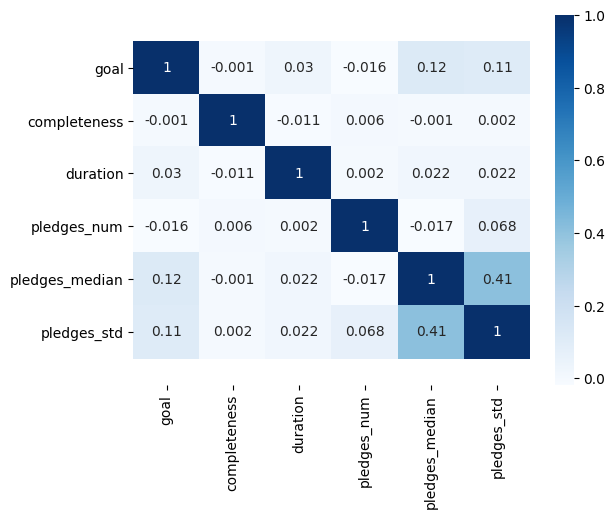

In [ ]:
plt.rcdefaults()
ax_corr = sns.heatmap(round(metadata.loc[:, ['goal','completeness','duration','pledges_num','pledges_median','pledges_std']].corr(),3), annot=True, cmap = "Blues")
bottom, top = ax_corr.get_ylim()
ax_corr.set_ylim(bottom + 0.5, top - 0.5)

(6.5, -0.5)

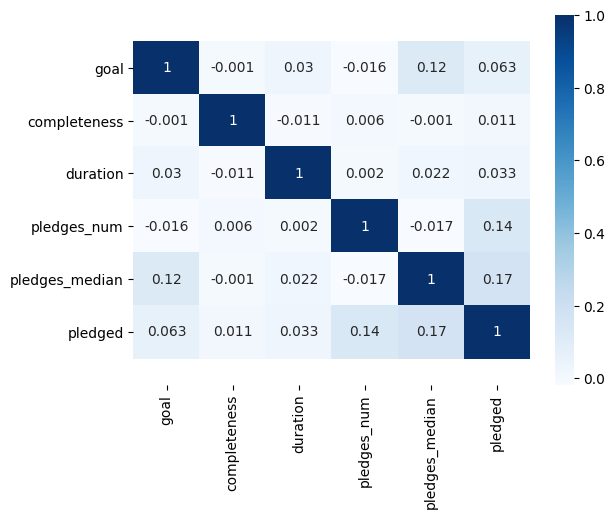

In [ ]:
plt.rcdefaults()
ax_corr = sns.heatmap(round(metadata.loc[:, ['goal','completeness','duration','pledges_num','pledges_median','pledged']].corr(),3), annot=True, cmap = "Blues")
bottom, top = ax_corr.get_ylim()
ax_corr.set_ylim(bottom + 0.5, top - 0.5)

(12.5, -0.5)

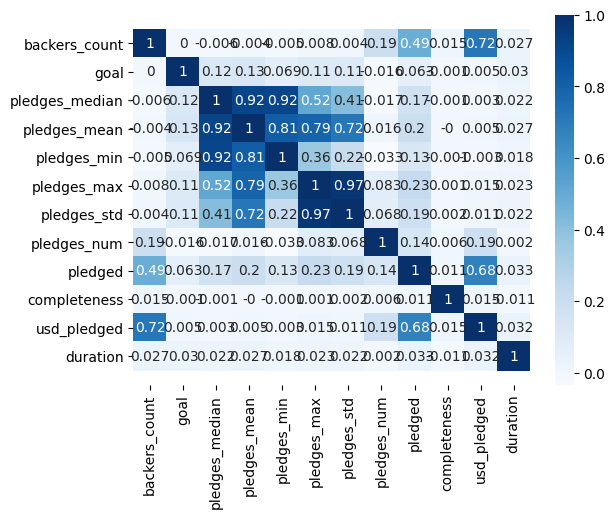

In [ ]:
plt.rcdefaults()
ax_corr = sns.heatmap(round(metadata.iloc[:, [0,4,6,7,8,9,10,11,12,13,14,15]].corr(),3), annot=True, cmap = "Blues")
bottom, top = ax_corr.get_ylim()
ax_corr.set_ylim(bottom + 0.5, top - 0.5)

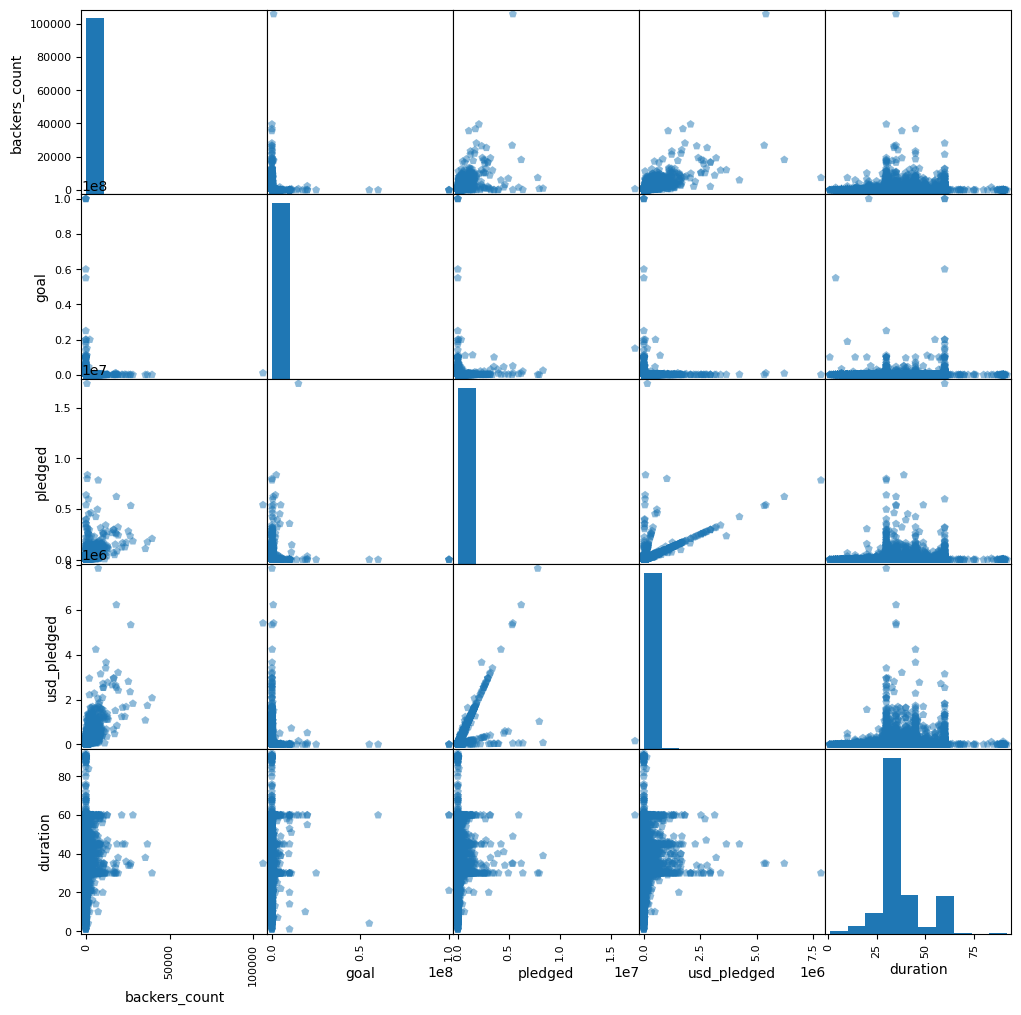

In [ ]:
pd.plotting.scatter_matrix(metadata.iloc[:, [0,4,12,14,15]], figsize= (12,12), marker = "p")
plt.show()

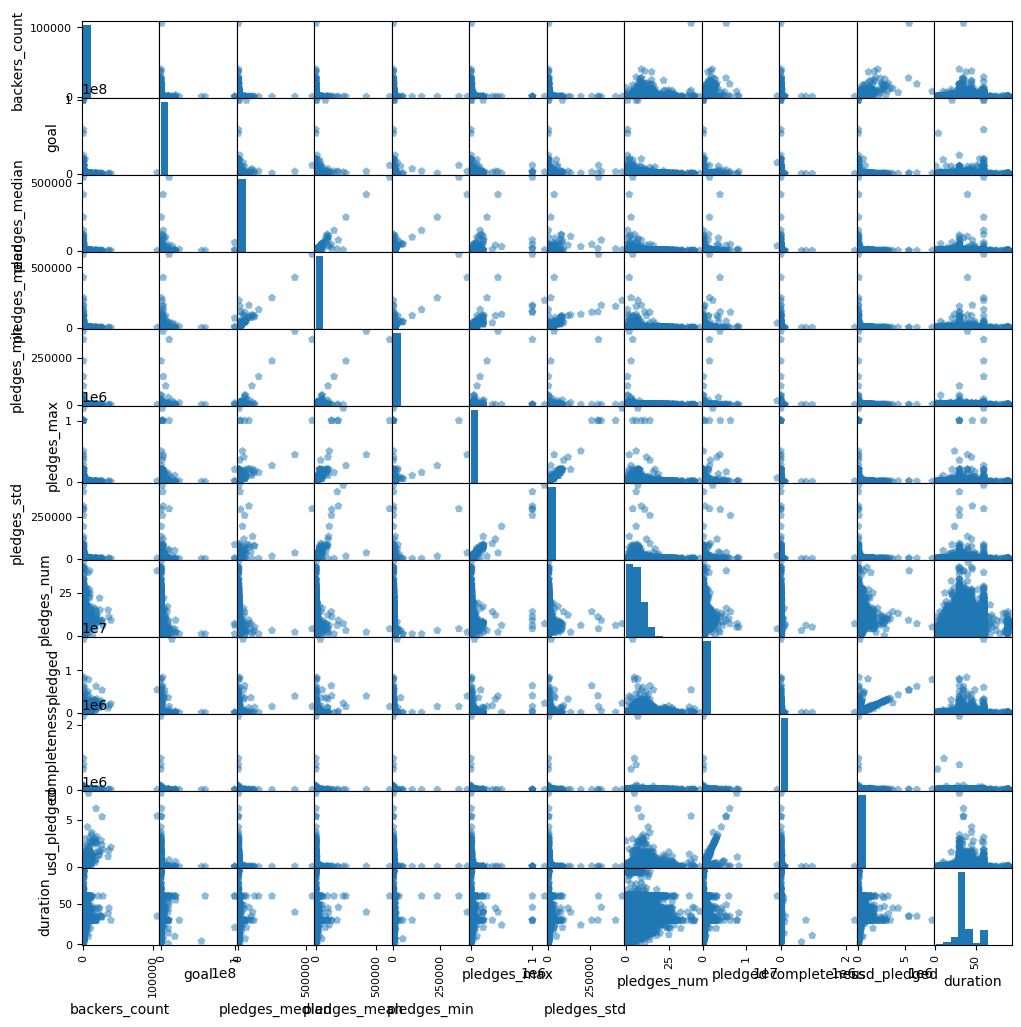

In [ ]:
pd.plotting.scatter_matrix(metadata.iloc[:, [0,4,6,7,8,9,10,11,12,13,14,15]], figsize= (12,12), marker = "p")
plt.show()

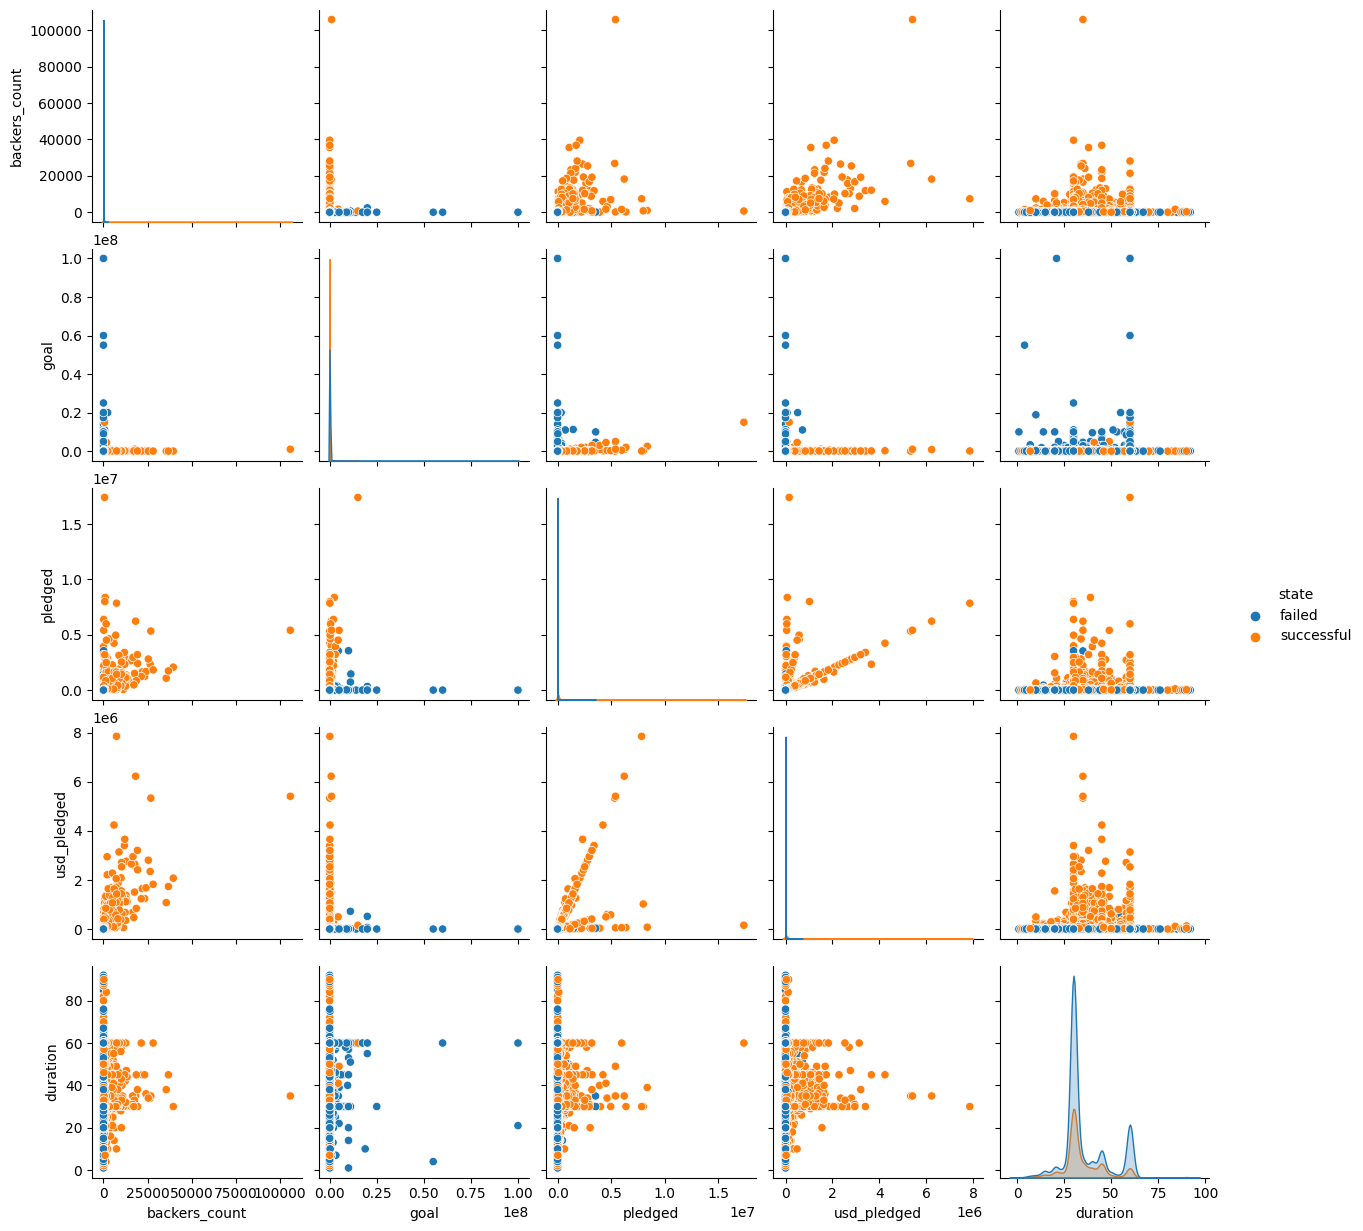

In [ ]:
sns.pairplot(metadata.iloc[:, [0,4,12,14,15,16]], hue = "state")     #Segmenta cada clase
plt.show()

# Separando en X & Y

### Primera combinatoria

In [ ]:
X = metadata.loc[:, ['goal','completeness','duration','pledges_num','backers_count','pledges_median']]
#X.iloc[:, 0] = pd.DataFrame(X.iloc[:, 0].apply(lambda x: x if x in ('Apps','Web','Hardware','Gadgets','Software') else 'OTHER'))
#X.iloc[:, 1] = pd.DataFrame(X.iloc[:, 1].apply(lambda x: x if x in ('US','GB','CA') else 'OTHER'))
X = X.values
X

array([[5.00e+04, 0.00e+00, 3.00e+01, 1.00e+00, 0.00e+00, 1.00e+01],
       [2.00e+03, 0.00e+00, 3.00e+01, 4.00e+00, 0.00e+00, 3.00e+01],
       [1.00e+05, 1.41e-01, 3.00e+01, 3.00e+00, 3.00e+00, 9.90e+01],
       ...,
       [7.50e+04, 0.00e+00, 3.00e+01, 2.00e+00, 0.00e+00, 1.00e+02],
       [2.50e+04, 4.80e-01, 6.00e+01, 1.00e+00, 2.00e+00, 2.50e+01],
       [6.00e+03, 0.00e+00, 3.80e+01, 5.00e+00, 0.00e+00, 1.00e+02]])

### Segunda combinatoria

In [ ]:
X = metadata.loc[:, ['goal','completeness','duration','pledges_num','backers_count','pledges_mean']]
X = X.values
X

array([[5.00000000e+04, 0.00000000e+00, 3.00000000e+01, 1.00000000e+00,
        0.00000000e+00, 1.00000000e+01],
       [2.00000000e+03, 0.00000000e+00, 3.00000000e+01, 4.00000000e+00,
        0.00000000e+00, 3.00000000e+01],
       [1.00000000e+05, 1.41000000e-01, 3.00000000e+01, 3.00000000e+00,
        3.00000000e+00, 1.12666667e+02],
       ...,
       [7.50000000e+04, 0.00000000e+00, 3.00000000e+01, 2.00000000e+00,
        0.00000000e+00, 1.00000000e+02],
       [2.50000000e+04, 4.80000000e-01, 6.00000000e+01, 1.00000000e+00,
        2.00000000e+00, 2.50000000e+01],
       [6.00000000e+03, 0.00000000e+00, 3.80000000e+01, 5.00000000e+00,
        0.00000000e+00, 5.27000000e+02]])

### Tercera combinatoria

In [ ]:
X = metadata.loc[:, ['goal','completeness','duration','pledges_num','backers_count','pledges_min','pledges_std']]
X = X.values
X

array([[5.00000000e+04, 0.00000000e+00, 3.00000000e+01, ...,
        0.00000000e+00, 1.00000000e+01, 0.00000000e+00],
       [2.00000000e+03, 0.00000000e+00, 3.00000000e+01, ...,
        0.00000000e+00, 1.00000000e+01, 1.68325082e+01],
       [1.00000000e+05, 1.41000000e-01, 3.00000000e+01, ...,
        3.00000000e+00, 4.00000000e+01, 8.03761988e+01],
       ...,
       [7.50000000e+04, 0.00000000e+00, 3.00000000e+01, ...,
        0.00000000e+00, 5.00000000e+01, 7.07106781e+01],
       [2.50000000e+04, 4.80000000e-01, 6.00000000e+01, ...,
        2.00000000e+00, 2.50000000e+01, 0.00000000e+00],
       [6.00000000e+03, 0.00000000e+00, 3.80000000e+01, ...,
        0.00000000e+00, 1.00000000e+01, 8.47360608e+02]])

### Cuarta combinatoria

In [ ]:
X = metadata.loc[:, ['goal','completeness','duration','pledges_num','backers_count','pledges_max']]
X = X.values
X

array([[5.00e+04, 0.00e+00, 3.00e+01, 1.00e+00, 0.00e+00, 1.00e+01],
       [2.00e+03, 0.00e+00, 3.00e+01, 4.00e+00, 0.00e+00, 5.00e+01],
       [1.00e+05, 1.41e-01, 3.00e+01, 3.00e+00, 3.00e+00, 1.99e+02],
       ...,
       [7.50e+04, 0.00e+00, 3.00e+01, 2.00e+00, 0.00e+00, 1.50e+02],
       [2.50e+04, 4.80e-01, 6.00e+01, 1.00e+00, 2.00e+00, 2.50e+01],
       [6.00e+03, 0.00e+00, 3.80e+01, 5.00e+00, 0.00e+00, 2.00e+03]])

### Quinta combinatoria

In [ ]:
X = metadata.loc[:, ['goal','completeness','duration','pledges_num','pledged','pledges_median']]
X = X.values
X

array([[5.00e+04, 0.00e+00, 3.00e+01, 1.00e+00, 0.00e+00, 1.00e+01],
       [2.00e+03, 0.00e+00, 3.00e+01, 4.00e+00, 0.00e+00, 3.00e+01],
       [1.00e+05, 1.41e-01, 3.00e+01, 3.00e+00, 1.41e+02, 9.90e+01],
       ...,
       [7.50e+04, 0.00e+00, 3.00e+01, 2.00e+00, 0.00e+00, 1.00e+02],
       [2.50e+04, 4.80e-01, 6.00e+01, 1.00e+00, 1.20e+02, 2.50e+01],
       [6.00e+03, 0.00e+00, 3.80e+01, 5.00e+00, 0.00e+00, 1.00e+02]])

### Sexta combinatoria

In [ ]:
X = metadata.loc[:, ['goal','completeness','duration','pledges_num','pledged','pledges_mean']]
X = X.values
X

array([[5.00000000e+04, 0.00000000e+00, 3.00000000e+01, 1.00000000e+00,
        0.00000000e+00, 1.00000000e+01],
       [2.00000000e+03, 0.00000000e+00, 3.00000000e+01, 4.00000000e+00,
        0.00000000e+00, 3.00000000e+01],
       [1.00000000e+05, 1.41000000e-01, 3.00000000e+01, 3.00000000e+00,
        1.41000000e+02, 1.12666667e+02],
       ...,
       [7.50000000e+04, 0.00000000e+00, 3.00000000e+01, 2.00000000e+00,
        0.00000000e+00, 1.00000000e+02],
       [2.50000000e+04, 4.80000000e-01, 6.00000000e+01, 1.00000000e+00,
        1.20000000e+02, 2.50000000e+01],
       [6.00000000e+03, 0.00000000e+00, 3.80000000e+01, 5.00000000e+00,
        0.00000000e+00, 5.27000000e+02]])

### Séptima combinatoria

In [ ]:
X = metadata.loc[:, ['goal','completeness','duration','pledges_num','pledged','pledges_min','pledges_std']]
X = X.values
X

array([[5.00000000e+04, 0.00000000e+00, 3.00000000e+01, ...,
        0.00000000e+00, 1.00000000e+01, 0.00000000e+00],
       [2.00000000e+03, 0.00000000e+00, 3.00000000e+01, ...,
        0.00000000e+00, 1.00000000e+01, 1.68325082e+01],
       [1.00000000e+05, 1.41000000e-01, 3.00000000e+01, ...,
        1.41000000e+02, 4.00000000e+01, 8.03761988e+01],
       ...,
       [7.50000000e+04, 0.00000000e+00, 3.00000000e+01, ...,
        0.00000000e+00, 5.00000000e+01, 7.07106781e+01],
       [2.50000000e+04, 4.80000000e-01, 6.00000000e+01, ...,
        1.20000000e+02, 2.50000000e+01, 0.00000000e+00],
       [6.00000000e+03, 0.00000000e+00, 3.80000000e+01, ...,
        0.00000000e+00, 1.00000000e+01, 8.47360608e+02]])

### Octava combinatoria

In [ ]:
X = metadata.loc[:, ['goal','completeness','duration','pledges_num','pledged','pledges_max']]
X = X.values
X

array([[5.00e+04, 0.00e+00, 3.00e+01, 1.00e+00, 0.00e+00, 1.00e+01],
       [2.00e+03, 0.00e+00, 3.00e+01, 4.00e+00, 0.00e+00, 5.00e+01],
       [1.00e+05, 1.41e-01, 3.00e+01, 3.00e+00, 1.41e+02, 1.99e+02],
       ...,
       [7.50e+04, 0.00e+00, 3.00e+01, 2.00e+00, 0.00e+00, 1.50e+02],
       [2.50e+04, 4.80e-01, 6.00e+01, 1.00e+00, 1.20e+02, 2.50e+01],
       [6.00e+03, 0.00e+00, 3.80e+01, 5.00e+00, 0.00e+00, 2.00e+03]])

### Novena combinatoria

In [ ]:
X = metadata.loc[:, ['goal','pledges_median','pledges_num','pledges_std','completeness','duration']]
X = X.values
X

array([[5.00000000e+04, 1.00000000e+01, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.00000000e+01],
       [2.00000000e+03, 3.00000000e+01, 4.00000000e+00, 1.68325082e+01,
        0.00000000e+00, 3.00000000e+01],
       [1.00000000e+05, 9.90000000e+01, 3.00000000e+00, 8.03761988e+01,
        1.41000000e-01, 3.00000000e+01],
       ...,
       [7.50000000e+04, 1.00000000e+02, 2.00000000e+00, 7.07106781e+01,
        0.00000000e+00, 3.00000000e+01],
       [2.50000000e+04, 2.50000000e+01, 1.00000000e+00, 0.00000000e+00,
        4.80000000e-01, 6.00000000e+01],
       [6.00000000e+03, 1.00000000e+02, 5.00000000e+00, 8.47360608e+02,
        0.00000000e+00, 3.80000000e+01]])

### Variable Y

In [ ]:
Y = metadata.loc[:, 'state'].values
Y = np.array(list(map(lambda x: 1 if x=="successful" else 0, Y)))
Y

array([0, 0, 0, ..., 0, 0, 0])

Ver este link sobre standarization y normalization:
*   https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc
*   https://www.kaggle.com/nirajvermafcb/support-vector-machine-detail-analysis



Fuente principal standarization: https://datascience.stackexchange.com/questions/16699/is-standardization-needed-before-using-scikit-learn-svm

# Separando en train y test

In [ ]:
train_ratio = 0.80
test_ratio = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1 - train_ratio, stratify = Y,random_state=0)

In [ ]:
# Importante !!!
# Escalado de variables
from sklearn.preprocessing import StandardScaler # Importan el modulo
from sklearn import preprocessing
#sc_X = StandardScaler()                          # Definir la funcion
sc_X = preprocessing.MinMaxScaler()
X_train = sc_X.fit_transform(X_train)            # Ajuste
X_test = sc_X.transform(X_test)                  # Aplicacion

In [ ]:
from pickle import dump

# Guardar el escalador
dump(sc_X, open('metadata_scaler.pkl', 'wb'))

# Cargar el escalador
#scaler = pickle.load(open('metadata_scaler.pkl', 'rb'))

In [ ]:
X_test

array([[4.99900005e-05, 1.13259302e-06, 1.44444444e-01, 1.39534884e-01,
        1.59948585e-05, 6.43382353e-05],
       [5.99900006e-05, 9.23918654e-06, 2.66666667e-01, 9.30232558e-02,
        1.56574669e-04, 2.78492647e-04],
       [3.49900003e-05, 2.52810942e-08, 3.22222222e-01, 1.16279070e-01,
        2.49919664e-07, 3.67647059e-05],
       ...,
       [3.34900003e-05, 7.92392504e-07, 3.22222222e-01, 4.65116279e-02,
        7.49758991e-06, 5.51470588e-05],
       [2.99990003e-04, 9.24656019e-07, 3.22222222e-01, 6.97674419e-02,
        7.83498146e-05, 4.59558824e-05],
       [4.99900005e-05, 4.61266204e-05, 3.22222222e-01, 9.30232558e-02,
        6.51415603e-04, 7.62867647e-05]])

In [ ]:
X_test.shape

(5451, 6)

In [ ]:
np.save('metadata_X_train.npy', X_train)
np.save('metadata_X_test.npy', X_test)

In [ ]:
np.save('metadata_Y_train.npy', y_train)
np.save('metadata_Y_test.npy', y_test)

# Experimentación con diferentes modelos

In [ ]:
# Fuente de ideas:
# https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

from numpy.random import seed
seed(0)
import tensorflow as tf
print(tf.__version__)
tf.random.set_seed(0)

2.4.0


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_sample_weight('balanced', np.unique(Y), Y)
# Para que funcione correctamente los pesos de las clases balanceadas, se almacenan como diccionarios
class_weights = {i : class_weights[i] for i in range(2)}
print(class_weights)

{0: 0.6987077585764833, 1: 1.7581290322580645}


In [ ]:
# Fuentes:
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://maelfabien.github.io/deeplearning/regu/#

# Para detener el entrenamiento cuando la pérdida en data de prueba empieza a subir. Límite de 2 incrementos.
# Para pérdida se usa mínimo. Para precisión se usa máximo
early_stopper = EarlyStopping( monitor='val_accuracy', patience=10, mode='auto')

# Para reducir tasa de aprendizaje cuando es muy grande
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1, min_delta=1e-2, mode='max')

In [ ]:
# Se tiene que dar acceso a Drive para almacenar el mejor modelo del checkpoint
# Fuente:
# https://medium.com/@mukesh.kumar43585/model-checkpoint-google-colab-and-drive-as-persistent-storage-for-long-training-runs-e35ffa0c33d9

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from keras.callbacks import *
checkpoint_path_NN ="/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint_NN = ModelCheckpoint(filepath=checkpoint_path_NN, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
os.path.dirname(checkpoint_path_NN)

'/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints'

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
# Añadir las capas de entrada y primera capa oculta
# Dense es un tipo de capa, la necesitamos codificar. 
# units : Numero de neuronas
# kernel_initializer : Inicializacion de pesos.
# activation : Funcion de activacion
# input_dim : Es el numero de variables o X o features.
#del model_nn

tf.keras.backend.clear_session()
model_nn = Sequential([
  # Añadir la capa de entrada y primera capa oculta
  # 6 entradas porque es el número de variables
  Dense(units = 32, activation = "relu", input_shape = (6,), kernel_initializer='normal'),
  Dropout(0.25),
  # Añadir la segunda capa oculta
  Dense(units = 16, activation = "tanh"),
  Dropout(0.3),
  # Añadir la capa de salida
  # Solo necesitamos una unidad pues tenemos un resultado binario (sigmoide).
  Dense(units = 1, activation = "sigmoid")
])

#opt = tf.keras.optimizers.Adam(learning_rate=2*1e-5)
#opt = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
opt = tf.keras.optimizers.Adam(learning_rate=0.005 , decay=1e-5)
model_nn.compile(loss='binary_crossentropy',optimizer= opt,metrics=['accuracy'])
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


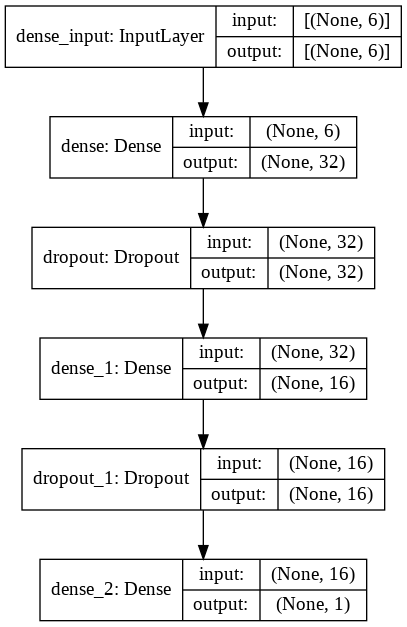

In [ ]:
plot_model(model_nn, to_file='model_nn_metadata.png', show_shapes=True, show_layer_names=True)

### Primera combinatoria

In [ ]:
from datetime import datetime
start = datetime.now()

# Ajustamos la RNA al Conjunto de Entrenamiento
# batch_size : Numero de observaciones antes de actualizar los pesos/ tamaño del bloque a procesar.
# epochs     : Numero de iteracciones globales / Mas veces mas aprendizaje u overfitting.
hist_nn = model_nn.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=100,
                       validation_data=(X_test, y_test),
                       verbose=1,
                       class_weight=class_weights,
                       callbacks=[early_stopper, reduce_lr_acc, checkpoint_NN]
                       )

stop=datetime.now()
execution_time_nn = stop-start

Epoch 1/100
682/682 [==============================] - 3s 3ms/step - loss: 0.5943 - accuracy: 0.6775 - val_loss: 0.3783 - val_accuracy: 0.8494

Epoch 00001: val_loss improved from inf to 0.37828, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:001-val_accuracy:0.849.hdf5
Epoch 2/100
682/682 [==============================] - 2s 3ms/step - loss: 0.4350 - accuracy: 0.8175 - val_loss: 0.3395 - val_accuracy: 0.8835

Epoch 00002: val_loss improved from 0.37828 to 0.33955, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:002-val_accuracy:0.884.hdf5
Epoch 3/100
682/682 [==============================] - 2s 3ms/step - loss: 0.3946 - accuracy: 0.8579 - val_loss: 0.3352 - val_accuracy: 0.8729

Epoch 00003: val_loss improved from 0.33955 to 0.33519, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardad

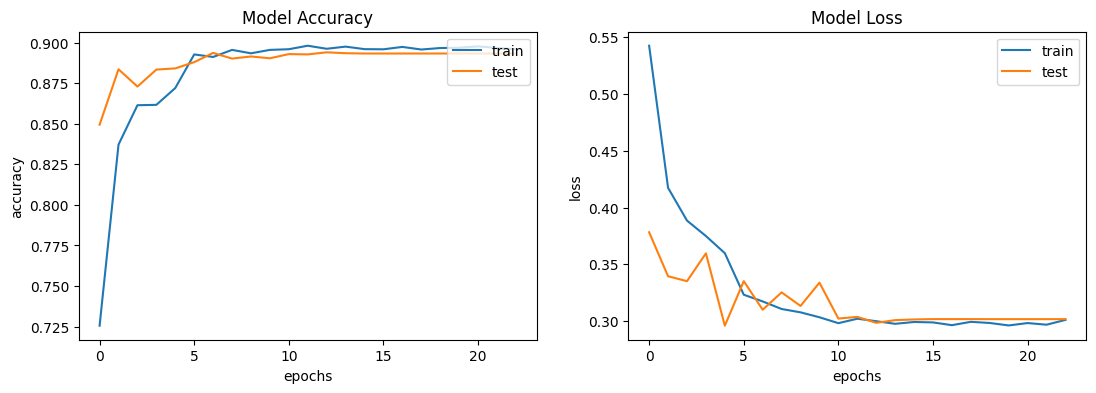

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_nn.history['accuracy'])
subfig.plot(hist_nn.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_nn.history['loss'])
subfig.plot(hist_nn.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:005-val_accuracy:0.884.hdf5'
#checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:021-val_accuracy:0.949.hdf5'
model_nn.load_weights(checkpoint_best_NN_path)

In [ ]:
score = model_nn.evaluate(X_test, y_test,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 0s 1ms/step - loss: 0.2960 - accuracy: 0.8841
Test loss:  0.2959722876548767
Test accuracy:  0.8840579986572266


171/171 [==============================] - 0s 852us/step


(2.5, -0.5)

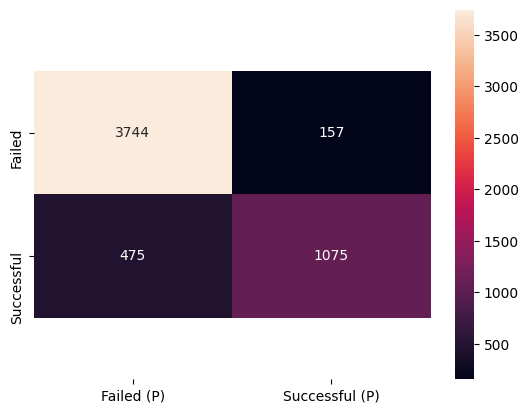

In [ ]:
#Importando métricas de scikit-learn para calcular precisión
from sklearn import metrics
plt.rcdefaults()

y_pred = model_nn.predict(X_test,verbose=1).ravel()
y_pred = np.round(y_pred)

conf_nn = metrics.confusion_matrix(y_test, y_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_nn = sns.heatmap(conf_nn, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_nn.get_ylim()
ax_nn.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.89      0.96      0.92      3901
  Successful       0.87      0.69      0.77      1550

    accuracy                           0.88      5451
   macro avg       0.88      0.83      0.85      5451
weighted avg       0.88      0.88      0.88      5451



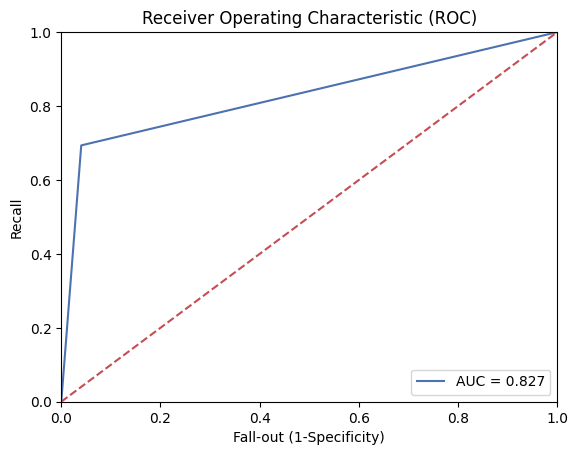

AUC score: 0.826651148175406


In [ ]:
plt.rcdefaults()
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc_nn = roc_auc_score(y_test,y_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_nn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_nn)

In [ ]:
gini_nn = (roc_auc_nn - 0.5) * 2
accuracy_nn = metrics.accuracy_score(y_test, y_pred)
f1_score_nn = metrics.f1_score(y_test, y_pred)
recall_score_nn = metrics.recall_score(y_test, y_pred)

In [ ]:
all_weights = []
rna_weights = model_nn.get_weights()
all_weights.extend([rna_weights])

dataframe_rna_weights = pd.DataFrame(rna_weights[4], columns=['rna_weights']) 
print (dataframe_rna_weights)
dataframe_rna_weights.to_csv('metada_rna_weights.csv', index = None, header=True)

    rna_weights
0      0.226701
1     -0.128880
2     -0.115938
3     -0.192599
4     -0.210669
..          ...
75    -0.227783
76     0.190895
77     0.252116
78     0.014352
79     0.026113

[80 rows x 1 columns]


In [ ]:
# save the model to disk
best_nn_model_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Mejores/best_NN_metadata_model.h5'
model_nn.save(best_nn_model_path)

### Segunda combinatoria

In [ ]:
from datetime import datetime
start = datetime.now()

# Ajustamos la RNA al Conjunto de Entrenamiento
# batch_size : Numero de observaciones antes de actualizar los pesos/ tamaño del bloque a procesar.
# epochs     : Numero de iteracciones globales / Mas veces mas aprendizaje u overfitting.
hist_nn = model_nn.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=100,
                       validation_data=(X_test, y_test),
                       verbose=1,
                       class_weight=class_weights,
                       callbacks=[early_stopper, reduce_lr_acc, checkpoint_NN]
                       )

stop=datetime.now()
execution_time_nn = stop-start

Epoch 1/100
682/682 [==============================] - 2s 3ms/step - loss: 0.6019 - accuracy: 0.6740 - val_loss: 0.3896 - val_accuracy: 0.8536

Epoch 00001: val_loss improved from inf to 0.38964, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:001-val_accuracy:0.854.hdf5
Epoch 2/100
682/682 [==============================] - 2s 3ms/step - loss: 0.4590 - accuracy: 0.7970 - val_loss: 0.3350 - val_accuracy: 0.8694

Epoch 00002: val_loss improved from 0.38964 to 0.33498, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:002-val_accuracy:0.869.hdf5
Epoch 3/100
682/682 [==============================] - 2s 3ms/step - loss: 0.4038 - accuracy: 0.8490 - val_loss: 0.3500 - val_accuracy: 0.8859

Epoch 00003: val_loss did not improve from 0.33498
Epoch 4/100
682/682 [==============================] - 2s 3ms/step - loss: 0.3834 - accurac

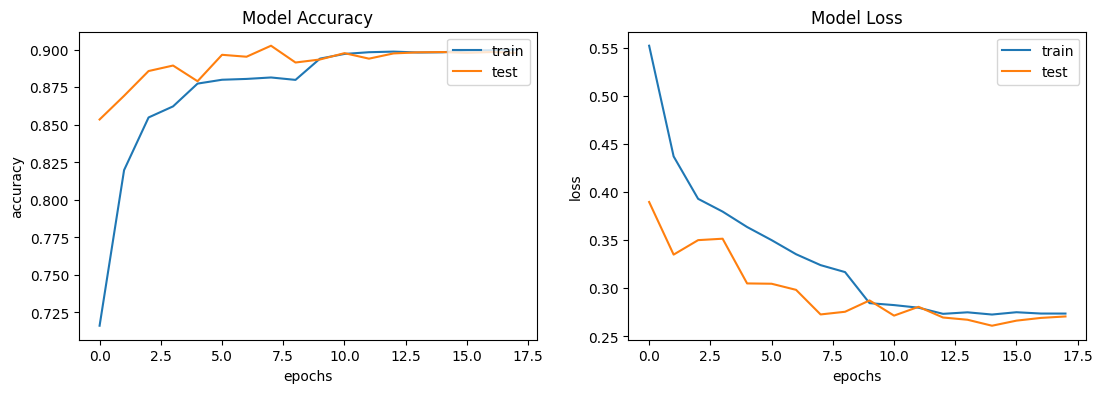

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_nn.history['accuracy'])
subfig.plot(hist_nn.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_nn.history['loss'])
subfig.plot(hist_nn.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:015-val_accuracy:0.899.hdf5'
#checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:021-val_accuracy:0.949.hdf5'
model_nn.load_weights(checkpoint_best_NN_path)

In [ ]:
score = model_nn.evaluate(X_test, y_test,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 0s 2ms/step - loss: 0.2611 - accuracy: 0.8986
Test loss:  0.2610958516597748
Test accuracy:  0.8985507488250732


171/171 [==============================] - 0s 883us/step


(2.5, -0.5)

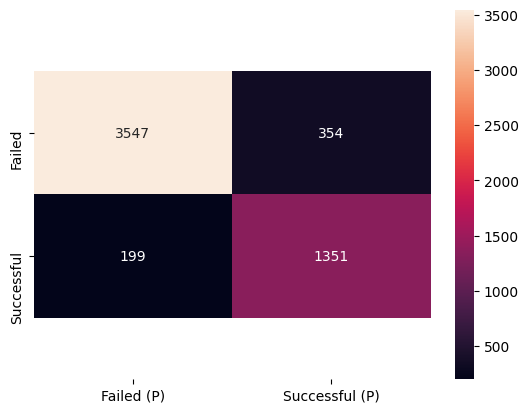

In [ ]:
#Importando métricas de scikit-learn para calcular precisión
from sklearn import metrics
plt.rcdefaults()

y_pred = model_nn.predict(X_test,verbose=1).ravel()
y_pred = np.round(y_pred)

conf_nn = metrics.confusion_matrix(y_test, y_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_nn = sns.heatmap(conf_nn, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_nn.get_ylim()
ax_nn.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.95      0.91      0.93      3901
  Successful       0.79      0.87      0.83      1550

    accuracy                           0.90      5451
   macro avg       0.87      0.89      0.88      5451
weighted avg       0.90      0.90      0.90      5451



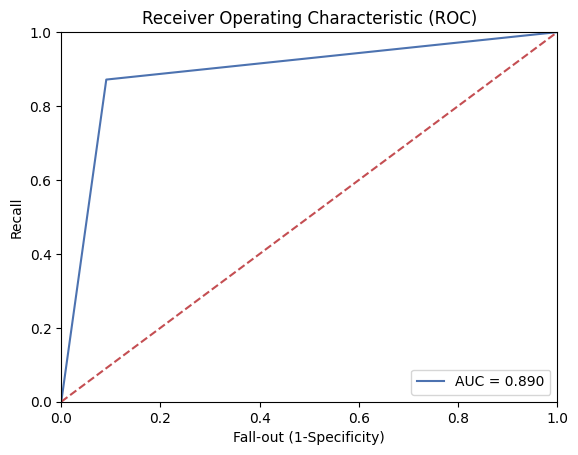

AUC score: 0.8904334703260537


In [ ]:
plt.rcdefaults()
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc_nn = roc_auc_score(y_test,y_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_nn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_nn)

### Tercera combinatoria

In [ ]:
from datetime import datetime
start = datetime.now()

# Ajustamos la RNA al Conjunto de Entrenamiento
# batch_size : Numero de observaciones antes de actualizar los pesos/ tamaño del bloque a procesar.
# epochs     : Numero de iteracciones globales / Mas veces mas aprendizaje u overfitting.
hist_nn = model_nn.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=100,
                       validation_data=(X_test, y_test),
                       verbose=1,
                       class_weight=class_weights,
                       callbacks=[early_stopper, reduce_lr_acc, checkpoint_NN]
                       )

stop=datetime.now()
execution_time_nn = stop-start

Epoch 1/100
682/682 [==============================] - 3s 3ms/step - loss: 0.5972 - accuracy: 0.6813 - val_loss: 0.3961 - val_accuracy: 0.8554

Epoch 00001: val_loss improved from inf to 0.39613, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:001-val_accuracy:0.855.hdf5
Epoch 2/100
682/682 [==============================] - 2s 3ms/step - loss: 0.4468 - accuracy: 0.8077 - val_loss: 0.3506 - val_accuracy: 0.8767

Epoch 00002: val_loss improved from 0.39613 to 0.35060, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:002-val_accuracy:0.877.hdf5
Epoch 3/100
682/682 [==============================] - 2s 3ms/step - loss: 0.4013 - accuracy: 0.8563 - val_loss: 0.3585 - val_accuracy: 0.8866

Epoch 00003: val_loss did not improve from 0.35060
Epoch 4/100
682/682 [==============================] - 2s 3ms/step - loss: 0.3972 - accurac

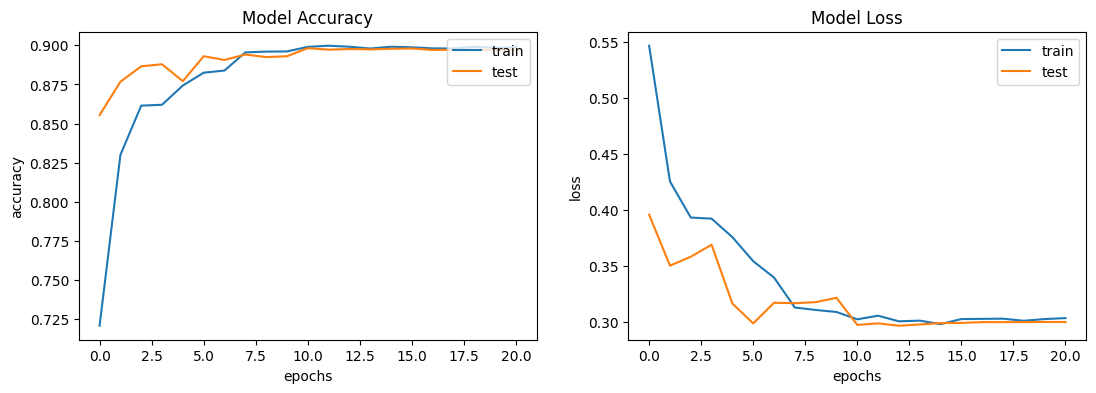

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_nn.history['accuracy'])
subfig.plot(hist_nn.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_nn.history['loss'])
subfig.plot(hist_nn.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:013-val_accuracy:0.898.hdf5'
#checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:021-val_accuracy:0.949.hdf5'
model_nn.load_weights(checkpoint_best_NN_path)

In [ ]:
score = model_nn.evaluate(X_test, y_test,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 0s 2ms/step - loss: 0.2969 - accuracy: 0.8976
Test loss:  0.2969381809234619
Test accuracy:  0.89763343334198


171/171 [==============================] - 0s 979us/step


(2.5, -0.5)

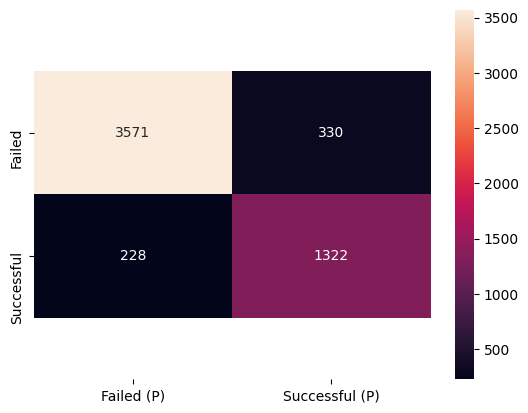

In [ ]:
#Importando métricas de scikit-learn para calcular precisión
from sklearn import metrics
plt.rcdefaults()

y_pred = model_nn.predict(X_test,verbose=1).ravel()
y_pred = np.round(y_pred)

conf_nn = metrics.confusion_matrix(y_test, y_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_nn = sns.heatmap(conf_nn, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_nn.get_ylim()
ax_nn.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.94      0.92      0.93      3901
  Successful       0.80      0.85      0.83      1550

    accuracy                           0.90      5451
   macro avg       0.87      0.88      0.88      5451
weighted avg       0.90      0.90      0.90      5451



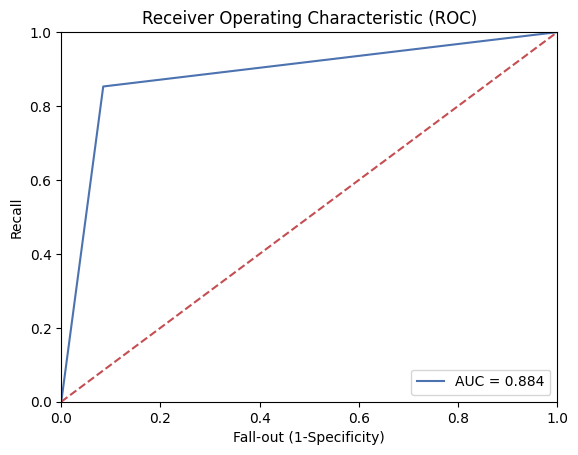

AUC score: 0.8841547659409086


In [ ]:
plt.rcdefaults()
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc_nn = roc_auc_score(y_test,y_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_nn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_nn)

### Cuarta combinatoria

In [ ]:
from datetime import datetime
start = datetime.now()

# Ajustamos la RNA al Conjunto de Entrenamiento
# batch_size : Numero de observaciones antes de actualizar los pesos/ tamaño del bloque a procesar.
# epochs     : Numero de iteracciones globales / Mas veces mas aprendizaje u overfitting.
hist_nn = model_nn.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=100,
                       validation_data=(X_test, y_test),
                       verbose=1,
                       class_weight=class_weights,
                       callbacks=[early_stopper, reduce_lr_acc, checkpoint_NN]
                       )

stop=datetime.now()
execution_time_nn = stop-start

Epoch 1/100
682/682 [==============================] - 3s 3ms/step - loss: 0.6027 - accuracy: 0.6766 - val_loss: 0.4051 - val_accuracy: 0.8477

Epoch 00001: val_loss improved from inf to 0.40507, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:001-val_accuracy:0.848.hdf5
Epoch 2/100
682/682 [==============================] - 2s 3ms/step - loss: 0.4534 - accuracy: 0.8006 - val_loss: 0.3501 - val_accuracy: 0.8815

Epoch 00002: val_loss improved from 0.40507 to 0.35013, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:002-val_accuracy:0.881.hdf5
Epoch 3/100
682/682 [==============================] - 2s 3ms/step - loss: 0.3996 - accuracy: 0.8514 - val_loss: 0.3406 - val_accuracy: 0.8897

Epoch 00003: val_loss improved from 0.35013 to 0.34056, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardad

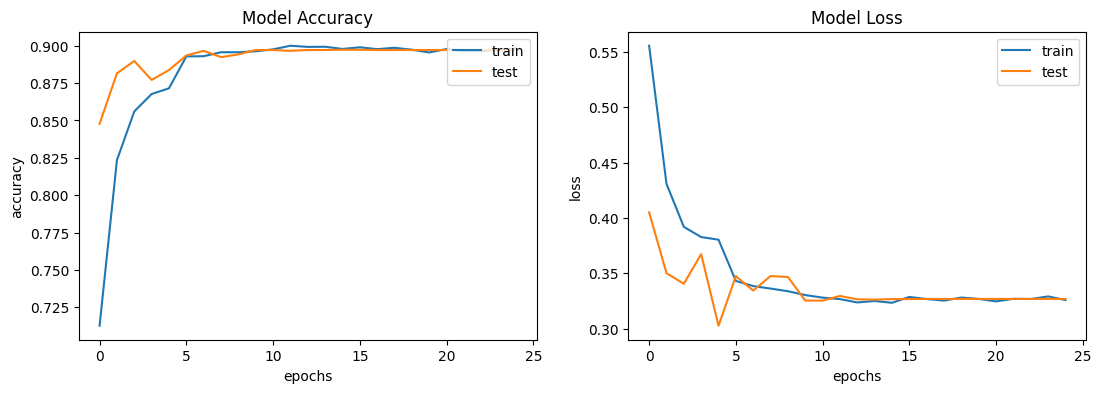

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_nn.history['accuracy'])
subfig.plot(hist_nn.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_nn.history['loss'])
subfig.plot(hist_nn.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:005-val_accuracy:0.884.hdf5'
#checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:021-val_accuracy:0.949.hdf5'
model_nn.load_weights(checkpoint_best_NN_path)

In [ ]:
score = model_nn.evaluate(X_test, y_test,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 0s 2ms/step - loss: 0.3027 - accuracy: 0.8837
Test loss:  0.30265918374061584
Test accuracy:  0.8836910724639893


171/171 [==============================] - 0s 989us/step


(2.5, -0.5)

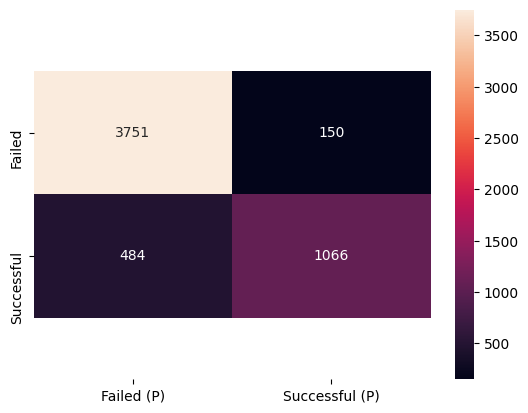

In [ ]:
#Importando métricas de scikit-learn para calcular precisión
from sklearn import metrics
plt.rcdefaults()

y_pred = model_nn.predict(X_test,verbose=1).ravel()
y_pred = np.round(y_pred)

conf_nn = metrics.confusion_matrix(y_test, y_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_nn = sns.heatmap(conf_nn, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_nn.get_ylim()
ax_nn.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.89      0.96      0.92      3901
  Successful       0.88      0.69      0.77      1550

    accuracy                           0.88      5451
   macro avg       0.88      0.82      0.85      5451
weighted avg       0.88      0.88      0.88      5451



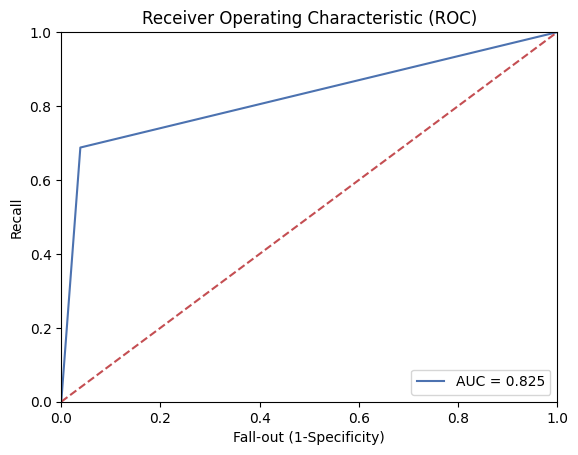

AUC score: 0.8246451282136094


In [ ]:
plt.rcdefaults()
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc_nn = roc_auc_score(y_test,y_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_nn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_nn)

### Quinta combinatoria

In [ ]:
from datetime import datetime
start = datetime.now()

# Ajustamos la RNA al Conjunto de Entrenamiento
# batch_size : Numero de observaciones antes de actualizar los pesos/ tamaño del bloque a procesar.
# epochs     : Numero de iteracciones globales / Mas veces mas aprendizaje u overfitting.
hist_nn = model_nn.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=100,
                       validation_data=(X_test, y_test),
                       verbose=1,
                       class_weight=class_weights,
                       callbacks=[early_stopper, reduce_lr_acc, checkpoint_NN]
                       )

stop=datetime.now()
execution_time_nn = stop-start

Epoch 1/100
682/682 [==============================] - 3s 3ms/step - loss: 0.6079 - accuracy: 0.6663 - val_loss: 0.4101 - val_accuracy: 0.8323

Epoch 00001: val_loss improved from inf to 0.41011, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:001-val_accuracy:0.832.hdf5
Epoch 2/100
682/682 [==============================] - 2s 3ms/step - loss: 0.4928 - accuracy: 0.7592 - val_loss: 0.3781 - val_accuracy: 0.8934

Epoch 00002: val_loss improved from 0.41011 to 0.37813, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:002-val_accuracy:0.893.hdf5
Epoch 3/100
682/682 [==============================] - 2s 3ms/step - loss: 0.4114 - accuracy: 0.8323 - val_loss: 0.3462 - val_accuracy: 0.9074

Epoch 00003: val_loss improved from 0.37813 to 0.34625, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardad

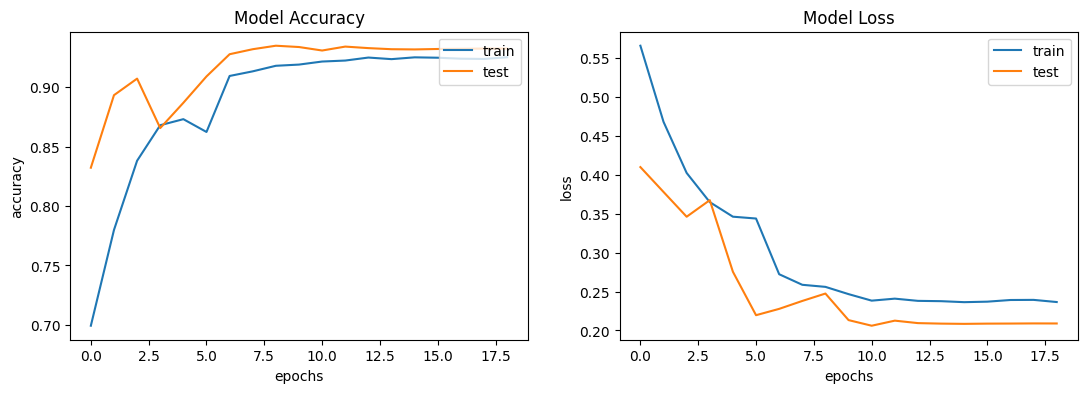

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_nn.history['accuracy'])
subfig.plot(hist_nn.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_nn.history['loss'])
subfig.plot(hist_nn.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:011-val_accuracy:0.931.hdf5'
model_nn.load_weights(checkpoint_best_NN_path)

In [ ]:
score = model_nn.evaluate(X_test, y_test,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 1s 1ms/step - loss: 0.2019 - accuracy: 0.9314
Test loss:  0.20602703094482422
Test accuracy:  0.9310218095779419


171/171 [==============================] - 0s 932us/step


(2.5, -0.5)

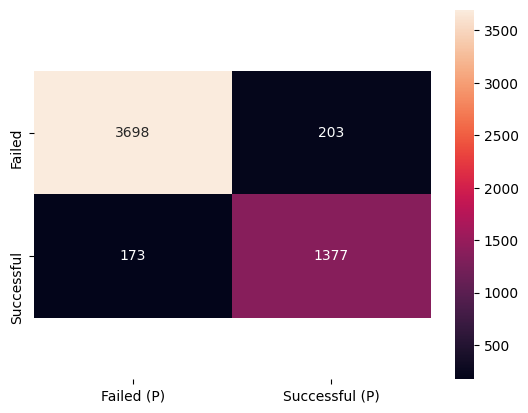

In [ ]:
#Importando métricas de scikit-learn para calcular precisión
from sklearn import metrics
plt.rcdefaults()

y_pred = model_nn.predict(X_test,verbose=1).ravel()
y_pred = np.round(y_pred)

conf_nn = metrics.confusion_matrix(y_test, y_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_nn = sns.heatmap(conf_nn, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_nn.get_ylim()
ax_nn.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.96      0.95      0.95      3901
  Successful       0.87      0.89      0.88      1550

    accuracy                           0.93      5451
   macro avg       0.91      0.92      0.92      5451
weighted avg       0.93      0.93      0.93      5451



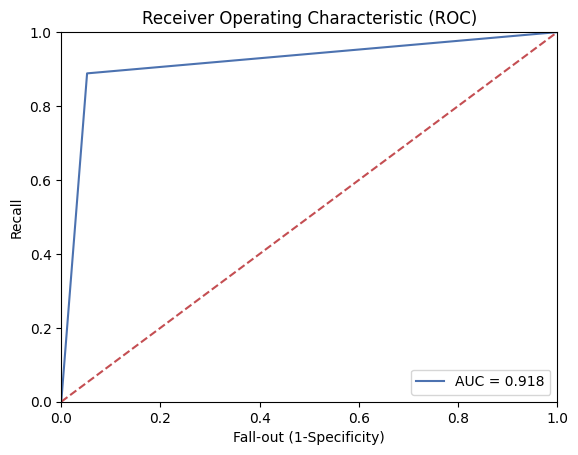

AUC score: 0.9181745788920955


In [ ]:
plt.rcdefaults()
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc_nn = roc_auc_score(y_test,y_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_nn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_nn)

### Sexta combinatoria

In [ ]:
from datetime import datetime
start = datetime.now()

# Ajustamos la RNA al Conjunto de Entrenamiento
# batch_size : Numero de observaciones antes de actualizar los pesos/ tamaño del bloque a procesar.
# epochs     : Numero de iteracciones globales / Mas veces mas aprendizaje u overfitting.
hist_nn = model_nn.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=100,
                       validation_data=(X_test, y_test),
                       verbose=1,
                       class_weight=class_weights,
                       callbacks=[early_stopper, reduce_lr_acc, checkpoint_NN]
                       )

stop=datetime.now()
execution_time_nn = stop-start

Epoch 1/100
682/682 [==============================] - 3s 3ms/step - loss: 0.6091 - accuracy: 0.6642 - val_loss: 0.4069 - val_accuracy: 0.8338

Epoch 00001: val_loss improved from inf to 0.40693, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:001-val_accuracy:0.834.hdf5
Epoch 2/100
682/682 [==============================] - 2s 3ms/step - loss: 0.4847 - accuracy: 0.7680 - val_loss: 0.3710 - val_accuracy: 0.8987

Epoch 00002: val_loss improved from 0.40693 to 0.37099, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:002-val_accuracy:0.899.hdf5
Epoch 3/100
682/682 [==============================] - 2s 3ms/step - loss: 0.3968 - accuracy: 0.8420 - val_loss: 0.3729 - val_accuracy: 0.8987

Epoch 00003: val_loss did not improve from 0.37099
Epoch 4/100
682/682 [==============================] - 2s 3ms/step - loss: 0.3564 - accurac

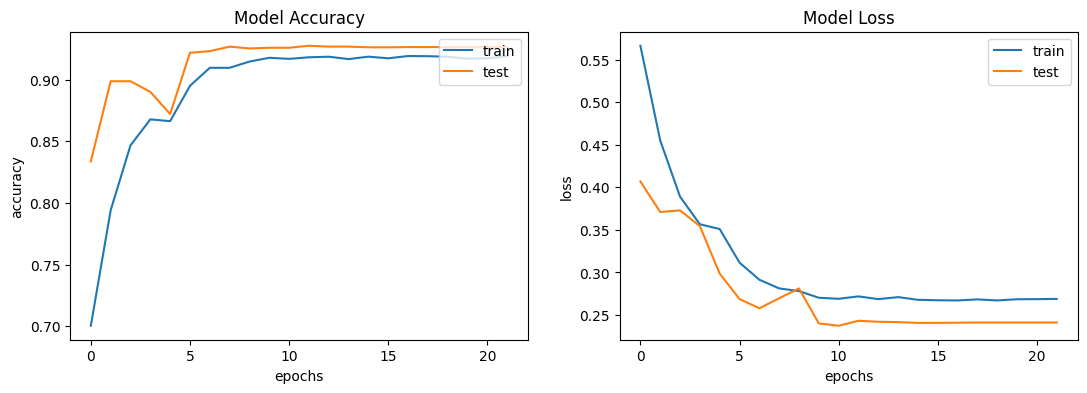

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_nn.history['accuracy'])
subfig.plot(hist_nn.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_nn.history['loss'])
subfig.plot(hist_nn.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:011-val_accuracy:0.926.hdf5'
#checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:021-val_accuracy:0.949.hdf5'
model_nn.load_weights(checkpoint_best_NN_path)

In [ ]:
score = model_nn.evaluate(X_test, y_test,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 0s 2ms/step - loss: 0.2373 - accuracy: 0.9259
Test loss:  0.23732107877731323
Test accuracy:  0.9258851408958435


171/171 [==============================] - 0s 940us/step


(2.5, -0.5)

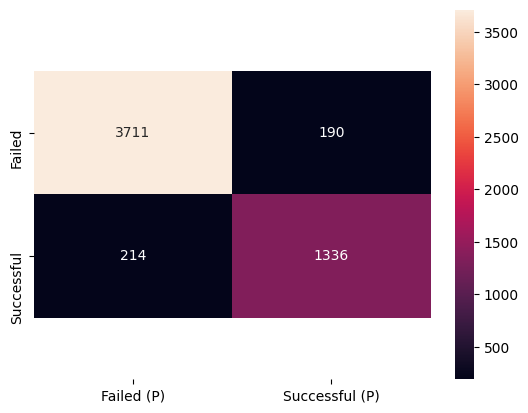

In [ ]:
#Importando métricas de scikit-learn para calcular precisión
from sklearn import metrics
plt.rcdefaults()

y_pred = model_nn.predict(X_test,verbose=1).ravel()
y_pred = np.round(y_pred)

conf_nn = metrics.confusion_matrix(y_test, y_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_nn = sns.heatmap(conf_nn, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_nn.get_ylim()
ax_nn.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.95      0.95      0.95      3901
  Successful       0.88      0.86      0.87      1550

    accuracy                           0.93      5451
   macro avg       0.91      0.91      0.91      5451
weighted avg       0.93      0.93      0.93      5451



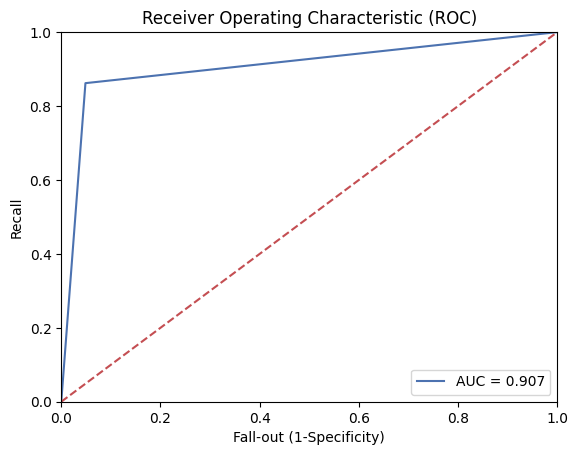

AUC score: 0.9066150118662708


In [ ]:
plt.rcdefaults()
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc_nn = roc_auc_score(y_test,y_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_nn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_nn)

### Séptima combinatoria

In [ ]:
from datetime import datetime
start = datetime.now()

# Ajustamos la RNA al Conjunto de Entrenamiento
# batch_size : Numero de observaciones antes de actualizar los pesos/ tamaño del bloque a procesar.
# epochs     : Numero de iteracciones globales / Mas veces mas aprendizaje u overfitting.
hist_nn = model_nn.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=100,
                       validation_data=(X_test, y_test),
                       verbose=1,
                       class_weight=class_weights,
                       callbacks=[early_stopper, reduce_lr_acc, checkpoint_NN]
                       )

stop=datetime.now()
execution_time_nn = stop-start

Epoch 1/100
682/682 [==============================] - 3s 3ms/step - loss: 0.6063 - accuracy: 0.6681 - val_loss: 0.4050 - val_accuracy: 0.8358

Epoch 00001: val_loss improved from inf to 0.40497, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:001-val_accuracy:0.836.hdf5
Epoch 2/100
682/682 [==============================] - 2s 3ms/step - loss: 0.4767 - accuracy: 0.7737 - val_loss: 0.3666 - val_accuracy: 0.8916

Epoch 00002: val_loss improved from 0.40497 to 0.36662, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:002-val_accuracy:0.892.hdf5
Epoch 3/100
682/682 [==============================] - 2s 3ms/step - loss: 0.3966 - accuracy: 0.8410 - val_loss: 0.3099 - val_accuracy: 0.8986

Epoch 00003: val_loss improved from 0.36662 to 0.30992, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardad

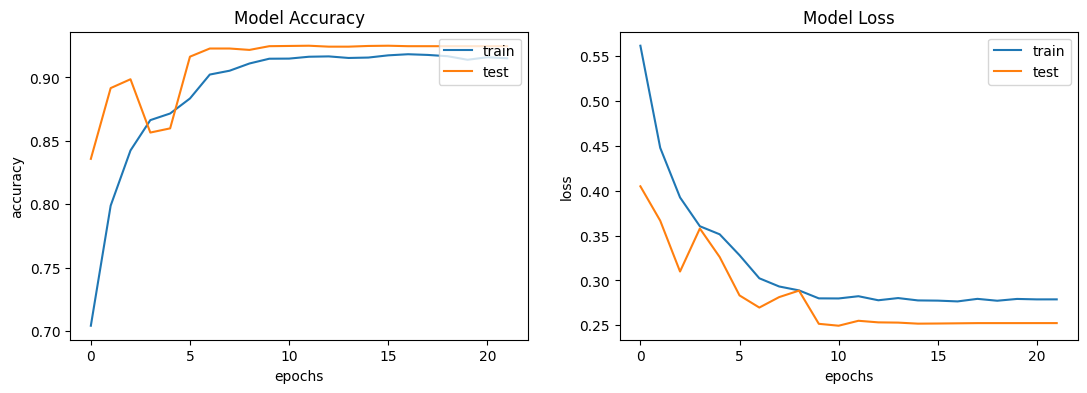

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_nn.history['accuracy'])
subfig.plot(hist_nn.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_nn.history['loss'])
subfig.plot(hist_nn.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:011-val_accuracy:0.925.hdf5'
#checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:021-val_accuracy:0.949.hdf5'
model_nn.load_weights(checkpoint_best_NN_path)

In [ ]:
score = model_nn.evaluate(X_test, y_test,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 0s 2ms/step - loss: 0.2495 - accuracy: 0.9248
Test loss:  0.2494804561138153
Test accuracy:  0.9247844219207764


171/171 [==============================] - 0s 877us/step


(2.5, -0.5)

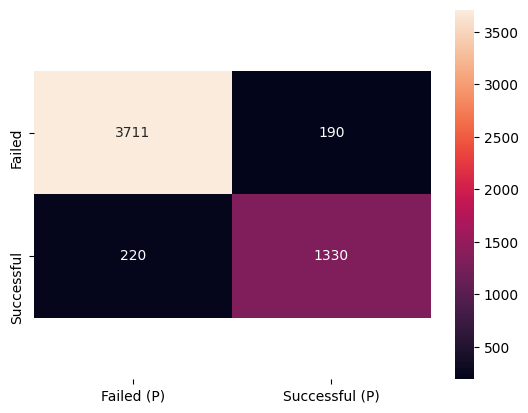

In [ ]:
#Importando métricas de scikit-learn para calcular precisión
from sklearn import metrics
plt.rcdefaults()

y_pred = model_nn.predict(X_test,verbose=1).ravel()
y_pred = np.round(y_pred)

conf_nn = metrics.confusion_matrix(y_test, y_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_nn = sns.heatmap(conf_nn, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_nn.get_ylim()
ax_nn.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.94      0.95      0.95      3901
  Successful       0.88      0.86      0.87      1550

    accuracy                           0.92      5451
   macro avg       0.91      0.90      0.91      5451
weighted avg       0.92      0.92      0.92      5451



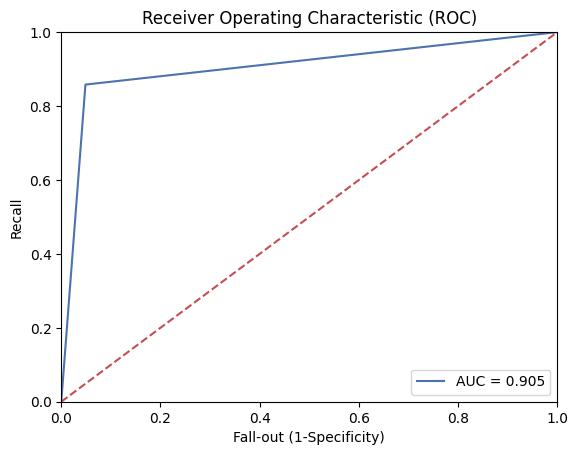

AUC score: 0.904679527995303


In [ ]:
plt.rcdefaults()
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc_nn = roc_auc_score(y_test,y_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_nn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_nn)

### Octava combinatoria

In [ ]:
from datetime import datetime
start = datetime.now()

# Ajustamos la RNA al Conjunto de Entrenamiento
# batch_size : Numero de observaciones antes de actualizar los pesos/ tamaño del bloque a procesar.
# epochs     : Numero de iteracciones globales / Mas veces mas aprendizaje u overfitting.
hist_nn = model_nn.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=100,
                       validation_data=(X_test, y_test),
                       verbose=1,
                       class_weight=class_weights,
                       callbacks=[early_stopper, reduce_lr_acc, checkpoint_NN]
                       )

stop=datetime.now()
execution_time_nn = stop-start

Epoch 1/100
682/682 [==============================] - 2s 3ms/step - loss: 0.6092 - accuracy: 0.6641 - val_loss: 0.4064 - val_accuracy: 0.8406

Epoch 00001: val_loss improved from inf to 0.40643, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:001-val_accuracy:0.841.hdf5
Epoch 2/100
682/682 [==============================] - 2s 3ms/step - loss: 0.4830 - accuracy: 0.7687 - val_loss: 0.3711 - val_accuracy: 0.8929

Epoch 00002: val_loss improved from 0.40643 to 0.37113, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:002-val_accuracy:0.893.hdf5
Epoch 3/100
682/682 [==============================] - 2s 3ms/step - loss: 0.3992 - accuracy: 0.8391 - val_loss: 0.3261 - val_accuracy: 0.9015

Epoch 00003: val_loss improved from 0.37113 to 0.32609, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardad

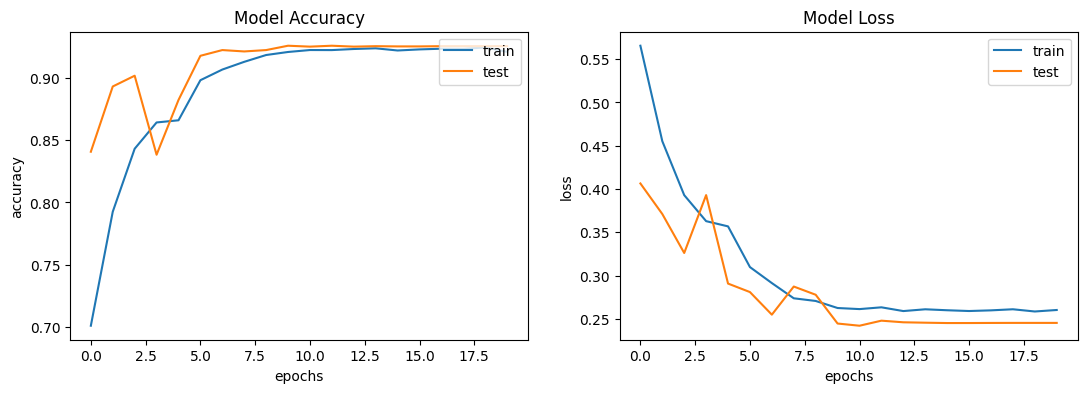

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_nn.history['accuracy'])
subfig.plot(hist_nn.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_nn.history['loss'])
subfig.plot(hist_nn.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:011-val_accuracy:0.925.hdf5'
#checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:021-val_accuracy:0.949.hdf5'
model_nn.load_weights(checkpoint_best_NN_path)

In [ ]:
score = model_nn.evaluate(X_test, y_test,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 0s 2ms/step - loss: 0.2420 - accuracy: 0.9248
Test loss:  0.2420463114976883
Test accuracy:  0.9247844219207764


171/171 [==============================] - 0s 867us/step


(2.5, -0.5)

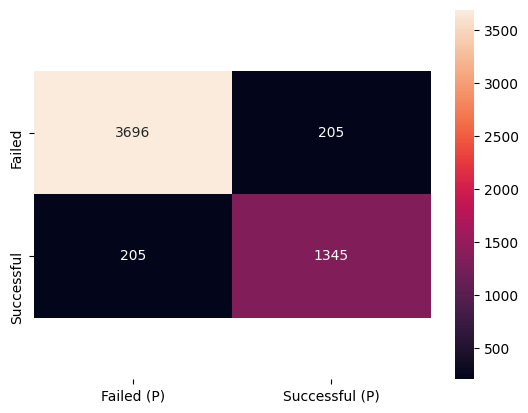

In [ ]:
#Importando métricas de scikit-learn para calcular precisión
from sklearn import metrics
plt.rcdefaults()

y_pred = model_nn.predict(X_test,verbose=1).ravel()
y_pred = np.round(y_pred)

conf_nn = metrics.confusion_matrix(y_test, y_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_nn = sns.heatmap(conf_nn, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_nn.get_ylim()
ax_nn.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.95      0.95      0.95      3901
  Successful       0.87      0.87      0.87      1550

    accuracy                           0.92      5451
   macro avg       0.91      0.91      0.91      5451
weighted avg       0.92      0.92      0.92      5451



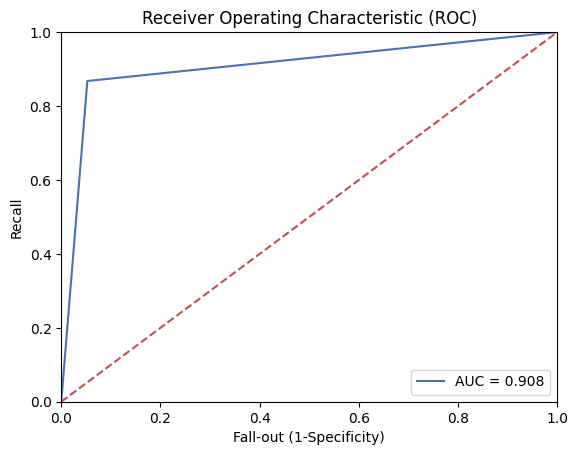

AUC score: 0.9075956537198898


In [ ]:
plt.rcdefaults()
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc_nn = roc_auc_score(y_test,y_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_nn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_nn)

### Novena combinatoria

In [ ]:
from datetime import datetime
start = datetime.now()

# Ajustamos la RNA al Conjunto de Entrenamiento
# batch_size : Numero de observaciones antes de actualizar los pesos/ tamaño del bloque a procesar.
# epochs     : Numero de iteracciones globales / Mas veces mas aprendizaje u overfitting.
hist_nn = model_nn.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=100,
                       validation_data=(X_test, y_test),
                       verbose=1,
                       class_weight=class_weights,
                       callbacks=[early_stopper, reduce_lr_acc, checkpoint_NN]
                       )

stop=datetime.now()
execution_time_nn = stop-start

Epoch 1/100
682/682 [==============================] - 3s 3ms/step - loss: 0.6303 - accuracy: 0.6332 - val_loss: 0.6513 - val_accuracy: 0.6014

Epoch 00001: val_loss improved from inf to 0.65134, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model2_epochs:001-val_accuracy:0.601.hdf5
Epoch 2/100
682/682 [==============================] - 2s 3ms/step - loss: 0.5993 - accuracy: 0.6536 - val_loss: 0.5800 - val_accuracy: 0.6663

Epoch 00002: val_loss improved from 0.65134 to 0.57996, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model2_epochs:002-val_accuracy:0.666.hdf5
Epoch 3/100
682/682 [==============================] - 2s 3ms/step - loss: 0.5849 - accuracy: 0.6713 - val_loss: 0.5980 - val_accuracy: 0.6197

Epoch 00003: val_loss did not improve from 0.57996
Epoch 4/100
682/682 [==============================] - 2s 3ms/step - loss: 0.5899 - accur

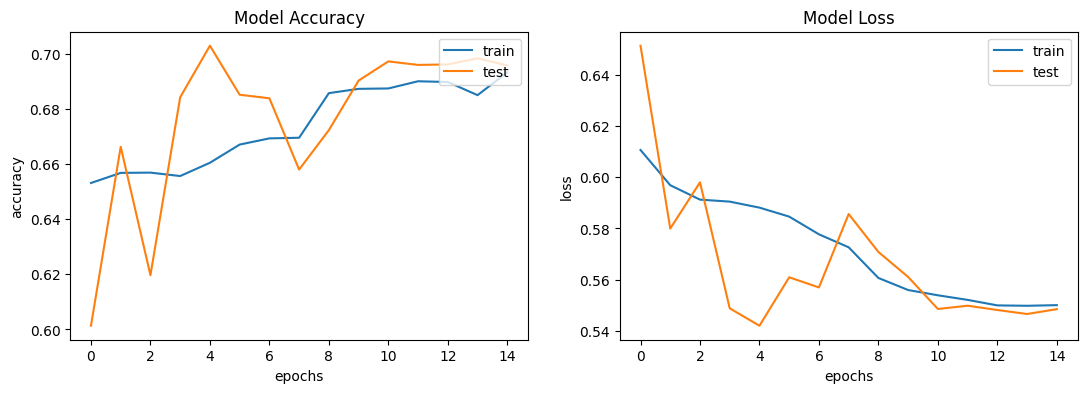

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_nn.history['accuracy'])
subfig.plot(hist_nn.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_nn.history['loss'])
subfig.plot(hist_nn.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model2_epochs:005-val_accuracy:0.703.hdf5'
#checkpoint_best_NN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_NN_metadata_model_epochs:021-val_accuracy:0.949.hdf5'
model_nn.load_weights(checkpoint_best_NN_path)

In [ ]:
score = model_nn.evaluate(X_test, y_test,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 0s 2ms/step - loss: 0.5420 - accuracy: 0.7030
Test loss:  0.5420279502868652
Test accuracy:  0.7029902935028076


171/171 [==============================] - 0s 950us/step


(2.5, -0.5)

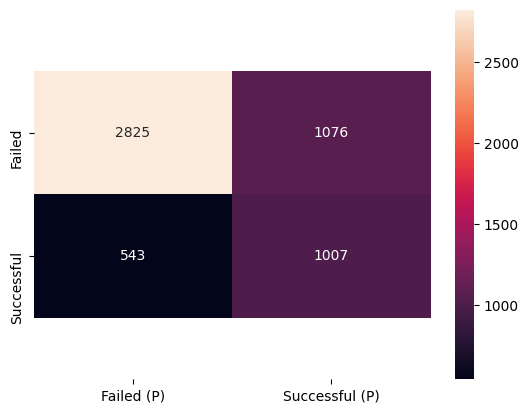

In [ ]:
#Importando métricas de scikit-learn para calcular precisión
from sklearn import metrics
plt.rcdefaults()

y_pred = model_nn.predict(X_test,verbose=1).ravel()
y_pred = np.round(y_pred)

conf_nn = metrics.confusion_matrix(y_test, y_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_nn = sns.heatmap(conf_nn, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_nn.get_ylim()
ax_nn.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.84      0.72      0.78      3901
  Successful       0.48      0.65      0.55      1550

    accuracy                           0.70      5451
   macro avg       0.66      0.69      0.67      5451
weighted avg       0.74      0.70      0.71      5451



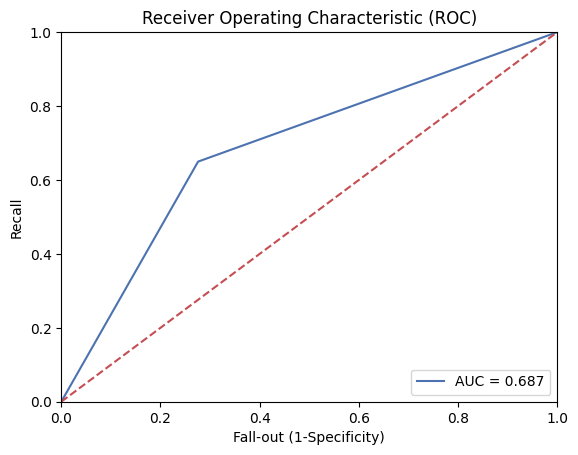

AUC score: 0.6869253541275604


In [ ]:
plt.rcdefaults()
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc_nn = roc_auc_score(y_test,y_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_nn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_nn)

## Guardar modelos

In [ ]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

# save the model to disk
#filename = 'best_svm_metadata_model.sav'
#pickle.dump(clf, open(filename, 'wb'))

# save the model to disk
#model_nn.save('best_NN_metadata_model.h5')
best_nn_model_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Mejores/best_NN_metadata_model.h5'
model_nn.save(best_nn_model_path)

# Evaluar modelos

Siempre es necesario tunear los hiperparámetros del modelo construido para determinar cuáles devolverán los mejores resultados.

Fuente: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [ ]:
### Evaluar la **RNA**
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

# Construimos un clasificador
def build_classifier():
  classifier = Sequential()
  classifier.add(Dense(units = 4, kernel_initializer = "lecun_uniform", activation = "relu", input_dim = 4))
  classifier.add(Dense(units = 2, kernel_initializer = "lecun_uniform", activation = "relu"))
  #classifier.add(BatchNormalization())
  classifier.add(Dropout(0.5))
  classifier.add(Dense(units = 1, kernel_initializer = "lecun_uniform", activation = "sigmoid"))
  opt = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
  classifier.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])
  return classifier

In [ ]:
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 32, nb_epoch = 100)
accuracies = cross_val_score(estimator=classifier, X = X_train, y = y_train, cv = 10, n_jobs=-1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.6s finished


In [ ]:
# Corroboramos si estamos ante un problema de Bias o Variance
mean = accuracies.mean()
variance = accuracies.std()

print(mean)
print(variance)

0.6569265991449356
0.13376660522941586


In [ ]:
### Mejorar la RNA
#### Regularización de Dropout para evitar el *overfitting*

### Ajustar la *RNA*
from sklearn.model_selection import GridSearchCV # sklearn.grid_search

def build_classifier(optimizer, kernel_initializer):
  classifier = Sequential()
  classifier.add(Dense(units = 4, kernel_initializer = kernel_initializer,  activation = "relu", input_dim = 4))
  classifier.add(Dense(units = 2, kernel_initializer = kernel_initializer,  activation = "relu"))
  #classifier.add(BatchNormalization())
  classifier.add(Dropout(0.5))
  classifier.add(Dense(units = 1, kernel_initializer = kernel_initializer,  activation = "sigmoid"))
  #optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
  classifier.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
  return classifier

In [ ]:
# Construimos el clasificador
classifier = KerasClassifier(build_fn = build_classifier)

# Hacemos el grid con los parámetros que queremos optimizar
parameters = {
    'batch_size' : [25,32],
    'nb_epoch' : [100, 250, 500], 
    'optimizer' : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    #'learn_rate' : [1E-4, 1E-5],
    'kernel_initializer' : ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
}

In [ ]:
grid_search = GridSearchCV(estimator = classifier, 
                           param_grid = parameters, 
                           scoring = 'accuracy', 
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train, class_weight = class_weights)

785/785 [==============================] - 2s 2ms/step - loss: 0.6935 - accuracy: 0.5548
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
682/682 [==============================] - 2s 2ms/step - loss: 0.6932 - accuracy: 0.6572


In [ ]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(best_parameters)
print(best_accuracy)

{'batch_size': 32, 'kernel_initializer': 'normal', 'nb_epoch': 100, 'optimizer': 'RMSprop'}
0.6781192660550458
